In [2]:
import torch
import torch.nn as nn  # neural network 모음 (e.g. nn.Linear, nn.Conv2d, BatchNorm, Loss functions 등)
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Generation (Preparation)
#### DataSet

In [6]:
# =====Generating Dataset===== #
random_numbers = np.random.rand(10000)*3  # 일정한 확률로 0~3 사이의 숫자 추출
angle = np.random.rand(10000)*2*np.pi
label = random_numbers.astype(int)        # np.array로 된 1개 이상의 리스트는 astype을 이용해서 타입 변경
random_numbers = random_numbers * (np.cos(angle) + 1)  # 같은 위치에 있는 값끼리 곱셈
x_1 = random_numbers * np.cos(angle)
x_2 = random_numbers * np.sin(angle)
x = np.array([x_1, x_2]).T


print(x.shape)
print(label.shape)

(10000, 2)
(10000,)


In [7]:
# =====Split Dataset into Train, Validation, Test===== #
X_train, y_train = x[:8000, :], label[:8000]
X_val, y_val = x[8000:9000, :], label[8000:9000]
X_test, y_test = x[9000:, :], label[9000:]
print(type(X_train))

<class 'numpy.ndarray'>


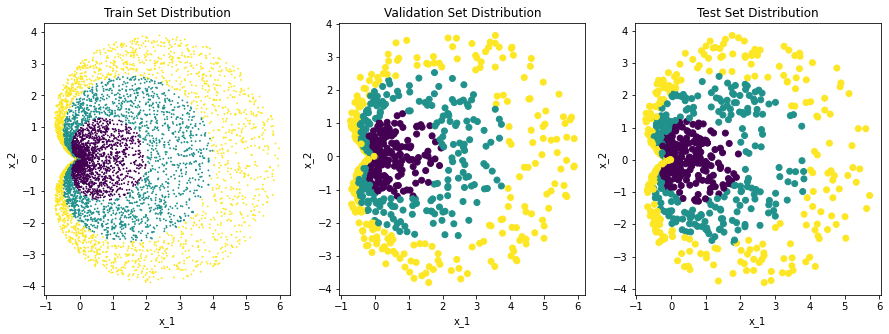

In [8]:
# =====Visualize Each Dataset===== #
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=0.7)
ax1.set_xlabel('x_1')
ax1.set_ylabel('x_2')
ax1.set_title('Train Set Distribution')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(X_val[:, 0], X_val[:, 1], c=y_val)
ax2.set_xlabel('x_1')
ax2.set_ylabel('x_2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
ax3.set_xlabel('x_1')
ax3.set_ylabel('x_2')
ax3.set_title('Test Set Distribution')

plt.show()

## 2. Hypothesis Define (Model Define)
- Model 내에서 Softmax를 사용할 필요가 없다  
    - 파이썬 내장 함수인 CrossEntropyLoss에 들어가 있음

In [9]:
class LinearModel(nn.Module):                # class 형태의 모델은 항상 nn.Module을 상속받음
    def __init__(self):
        super(LinearModel, self).__init__()  # nn.Module.__init__() 을 실행시키는 코드
        self.lin_layer = nn.Linear(in_features=2, out_features=3, bias=True)  # in_features : size of input sample / bias=False : layer가 편향을 학습하지 않음
        
    def forward(self, x):                    # forward : 학습 데이터를 입력받아 forward propagation을 진행하는 함수
        x = self.lin_layer(x)
        return x
    
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.lin_layer1 = nn.Linear(in_features=2, out_features=200)
        self.lin_layer2 = nn.Linear(in_features=200, out_features=3)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.lin_layer1(x)
        x = self.ReLU(x)
        x = self.lin_layer2(x)
        return x

## 3. Cost Function Define(Loss Function Define)

In [10]:
criterion = nn.CrossEntropyLoss()

# Cross Entropy 테스트
pred_y = torch.Tensor([[2,0.1], [0,1]])  # 첫 번째 차원 : batch size, 두 번째 차원 : 예측값인 확률
true_y1 = torch.Tensor([1,0]).long()  # long : 정수형 타입 / Tensor는 처음 만들어질 때 float 형
true_y2 = torch.Tensor([0,1]).long()
print(pred_y)
print(criterion(pred_y, true_y1))
print(criterion(pred_y, true_y2))


tensor([[2.0000, 0.1000],
        [0.0000, 1.0000]])
tensor(1.6763)
tensor(0.2263)


## Train & Evaluation
- 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서, 동시에 Validation Set을 넣고 Loss를 비교함
- 우리가 평가하고 싶을 때마다 (여기선 200번) Test set을 넣고 Visualize 하는데 필요한 Predicted y 값과 Metric값을 계산
- 이번에는 Classification Task에서 기본적으로 사용하는  Accuracy를 Metric으로 활용
- Accuracy를 계산하는 함수가 이미 sklearn.metrics에 구현되어 있으니 불러와서 사용

In [18]:
import torch.optim as optim  # Optimization algorithm 모음 (e.g. SGD, Adam 등)
from sklearn.metrics import accuracy_score

# =====Construct Model===== #
model = LinearModel()        # Model 생성

# count trainable model parameters only
print('{} parameters'. format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# =====Construct Optimizer===== #
lr  = 0.005  # lr를 하나 정해줌 (원활환 학습을 위해 손을 많이 탐)
optimizer = optim.SGD(model.parameters(), lr=lr)  # Optimizer 생성

# 매 학습 단계에서의 epoch 값과 그 때의 loss 값을 저장할 list 만들기
epoch_lst = []
train_loss = []
val_loss = []
acc = []
acc_epoch = []

epoch = 4000  # 학습 횟수(epoch)를 지정

9 parameters


torch.Size([8000, 2]) torch.Size([8000]) torch.Size([8000, 3])


ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 8000.

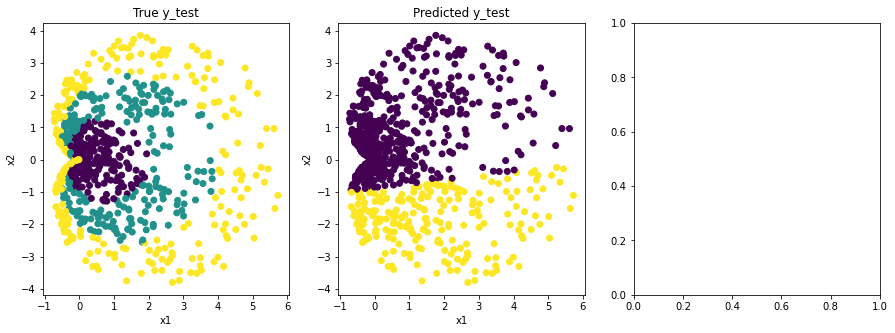

In [22]:
for i in range(epoch):
    # =====Train===== #
    model.train()          # model을 학습 모드로 세팅 / 모델 평가 시 model.eval() 모드로 변경
    optimizer.zero_grad()  # optimizer에 남아있을 수도 있는 잔여 gradient를 모두 0으로 초기화
    
    input_x = torch.Tensor(X_train)
    real_y = torch.Tensor(y_train).long()   # .long() : int64
    predict_y = model(input_x)
    print(input_x.shape, real_y.shape, predict_y.shape)  # 각 input과 output의 차원을 확인
    
    loss = criterion(predict_y.squeeze(), real_y)
    loss.backward()        # backward()를 통해서 gradient를 구함
    optimizer.step()       # step()을 통해서 gradient를 바탕으로 parameter를 업데이트
    epoch_lst.append(i)
    train_loss.append(loss.detach().numpy())  # Tensor -> numpy로 변경
    
    # =====Validation===== #
    model.eval()
    input_x = torch.Tensor(X_val)
    real_y = torch.Tensor(y_val).long()
    predict_y = model(input_x)
    loss = criterion(predict_y.squeeze(), real_y)
    val_loss.append(loss.detach().numpy())
    
    # =====Evaluation===== #
    if i % 200 == 0:  # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그림
        
        # =====Calculate Accuracy===== #
        model.eval()
        input_x = torch.Tensor(X_test)
        real_y = torch.Tensor(y_test).long()
        predict_y = model(input_x).detach().max(dim=1)[1].numpy()
        accuracy = accuracy_score(real_y, predict_y)  # sklearn 함수들은 real_y가 먼저, predict_y가 나중에 인자로 들어가는 것에 주의!
        acc.append(accuracy)
        acc_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True y_test')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(X_test[:, 0], X_test[:, 1], c=predict_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted y_test')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(X_train)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(X_train[:, 0], X_train[:, 1], c=predict_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

## 5. Report Experiment
- 학습 과정에서 기록했던 train_loss와 val_loss 그리기

In [ ]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epoch_lst, train_loss, label='train_loss')
ax1.plot(epoch_lst, val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(acc_epoch, acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()